In [9]:
import numpy as onp
import jax.numpy as jnp
import jax
from jaxri import lnprob, priors
from matplotlib import pyplot as plt

from jax.experimental import optimizers

In [2]:
ground_truth = onp.zeros((500, 500))
ground_truth[250, 250] = 5

In [4]:
uv_arr = jnp.asarray(onp.loadtxt('../test-data/random_baselines.csv', delimiter=','))
model_im = jnp.asarray(ground_truth)
lm_arr = jnp.indices(model_im.shape)
vis_obs = jnp.asarray(lnprob.simulate(uv_arr, lm_arr, model_im, sigma=0))

In [4]:
def compute_i(uv: jnp.array, lm: jnp.array, vis: jnp.array):
    l, m = lm
    u, v = uv
    return jnp.sum(vis * jnp.exp(2 * jnp.pi * 1j * (u * l + v * m)))

vmapped_compute_i = jax.vmap(compute_i, in_axes=(None, 0, None))

In [7]:
im_dft = vmapped_compute_i(uv_arr.T, lm_arr.reshape(2, 500**2).T, vis_obs)

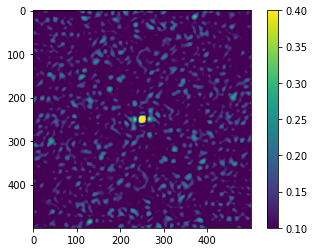

In [17]:
NORM = 500
plt.imshow(jnp.abs(im_dft/NORM).reshape(500, 500), vmin=0.1, vmax=0.4)
plt.colorbar()

# Cat!

In [31]:
uv_arr = jnp.asarray(onp.loadtxt('../test-data/random_baselines.csv', delimiter=','))
model_im = jnp.asarray(onp.load('../test-data/cat.npy') * 5)
lm_arr = jnp.indices(model_im.shape)
vis_obs = jnp.asarray(lnprob.simulate(uv_arr, lm_arr, model_im, sigma=1))

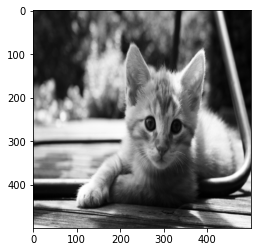

In [43]:
plt.imshow(model_im, cmap='gray')

In [33]:
model_im.max()

DeviceArray(4.8248715, dtype=float32)

In [34]:
im_dft = vmapped_compute_i(uv_arr.T, lm_arr.reshape(2, 500**2).T, vis_obs)

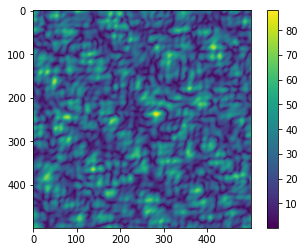

In [35]:
NORM = 500
plt.imshow(jnp.abs(im_dft/NORM).reshape(500, 500))
plt.colorbar()

In [36]:
def like(im):
    return -lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, 0.1)

In [37]:
rng = jax.random.PRNGKey(65)
init_params = jax.random.normal(rng, shape=(500, 500)) * 0.01 + 1
init_fun, update_fun, get_params = optimizers.adam(1e-4)
opt_state = init_fun(init_params)
def update(step, opt_state):
    value, grads = jax.value_and_grad(like)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state
j_update = jax.jit(update)

In [38]:
loss_list = []
opt_state = init_fun(init_params)
for step in range(10000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

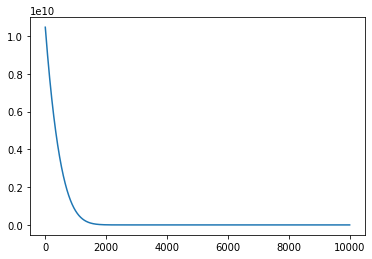

In [40]:
plt.plot(loss_list)

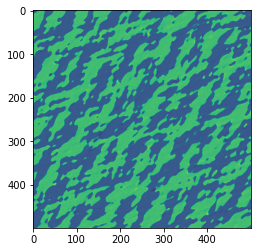

In [41]:
plt.imshow(get_params(opt_state))